In [8]:
from google.colab import files

uploaded = files.upload()


Saving delhi_aqi.csv to delhi_aqi (1).csv


In [40]:
# DATA PREPROCESSING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

df = pd.read_csv("delhi_aqi.csv")

print("Initial Shape:", df.shape)
print(df.head())

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df = df.dropna(subset=['date'])
df = df.sort_values('date')
df = df.drop_duplicates()
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']


df[pollutants] = df[pollutants].fillna(df[pollutants].mean())


df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Summer"
    elif month in [6, 7, 8]:
        return "Monsoon"
    else:
        return "Post-Monsoon"

df['season'] = df['month'].apply(get_season)

def remove_outliers(df, cols):
    cleaned_df = df.copy()
    for col in cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
    return cleaned_df

df = remove_outliers(df, pollutants)

print("After Outlier Removal:", df.shape)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[pollutants])

scaled_df = pd.DataFrame(scaled_data, columns=[col + "_scaled" for col in pollutants])

# Merge scaled features back into dataframe
df = pd.concat([df.reset_index(drop=True), scaled_df], axis=1)


Initial Shape: (18776, 9)
                  date       co     no     no2     o3    so2   pm2_5    pm10  \
0  2020-11-25 01:00:00  2616.88   2.18   70.60  13.59  38.62  364.61  411.73   
1  2020-11-25 02:00:00  3631.59  23.25   89.11   0.33  54.36  420.96  486.21   
2  2020-11-25 03:00:00  4539.49  52.75  100.08   1.11  68.67  463.68  541.95   
3  2020-11-25 04:00:00  4539.49  50.96  111.04   6.44  78.20  454.81  534.00   
4  2020-11-25 05:00:00  4379.27  42.92  117.90  17.17  87.74  448.14  529.19   

     nh3  
0  28.63  
1  41.04  
2  49.14  
3  48.13  
4  46.61  
After Outlier Removal: (12621, 13)


           pm2_5        pm10
year                        
2020  193.058323  226.750084
2021  127.156022  168.655858
2022  119.642017  161.301721
2023  234.096193  270.165937


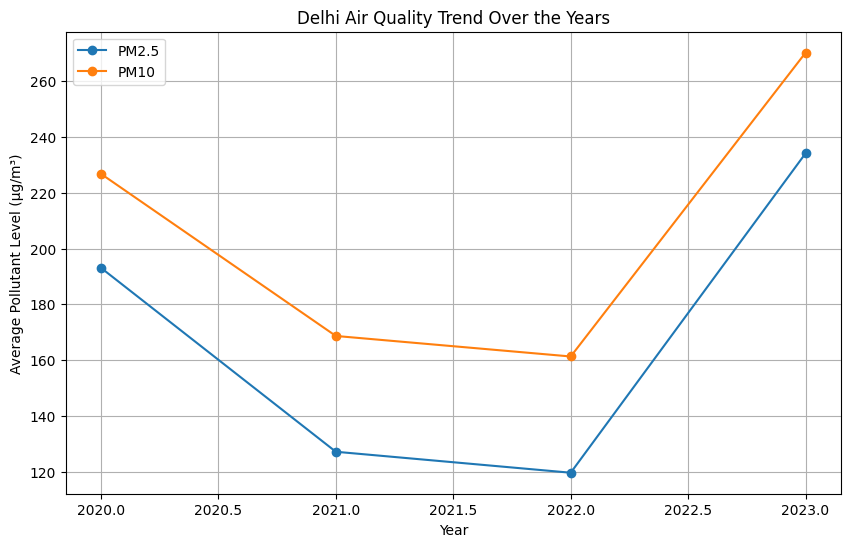

In [33]:
# DELHI AIR QUALITY TRENDS OVER THE YEARS

df['date'] = pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year

yearly_trend = df.groupby('year')[['pm2_5', 'pm10']].mean()
print(yearly_trend)



plt.figure(figsize=(10,6))

plt.plot(yearly_trend.index, yearly_trend['pm2_5'], marker='o', label='PM2.5')
plt.plot(yearly_trend.index, yearly_trend['pm10'], marker='o', label='PM10')

plt.title("Delhi Air Quality Trend Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Pollutant Level (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()





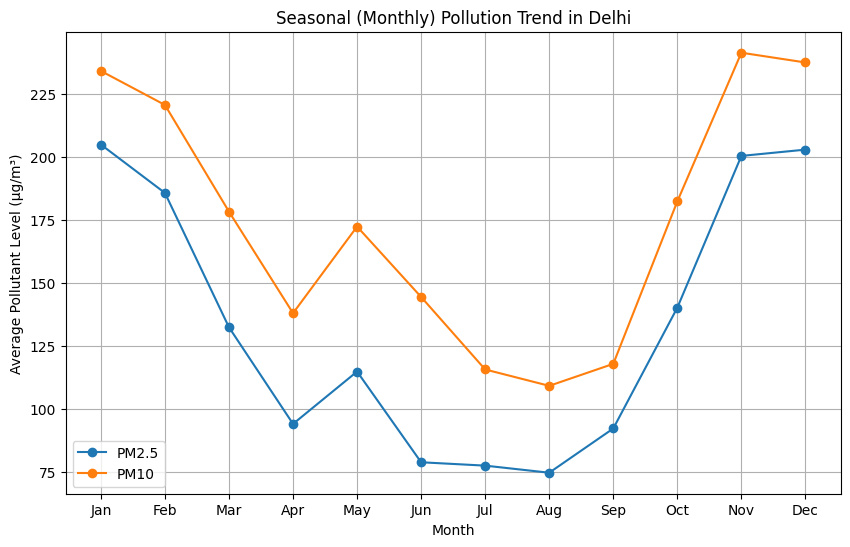

In [34]:
# MONTHLY TRENDS IN DELHI
plt.figure(figsize=(10,6))
monthly_trend = df.groupby('month')[['pm2_5', 'pm10']].mean()

plt.plot(monthly_trend.index, monthly_trend['pm2_5'], marker='o', label='PM2.5')
plt.plot(monthly_trend.index, monthly_trend['pm10'], marker='o', label='PM10')

plt.title("Seasonal (Monthly) Pollution Trend in Delhi")
plt.xlabel("Month")
plt.ylabel("Average Pollutant Level (µg/m³)")
plt.grid(True)
plt.xticks(range(1,13),
           ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.legend()
plt.show()


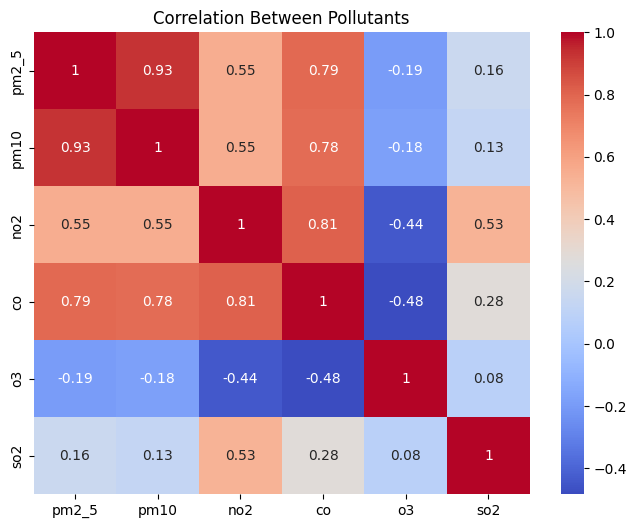

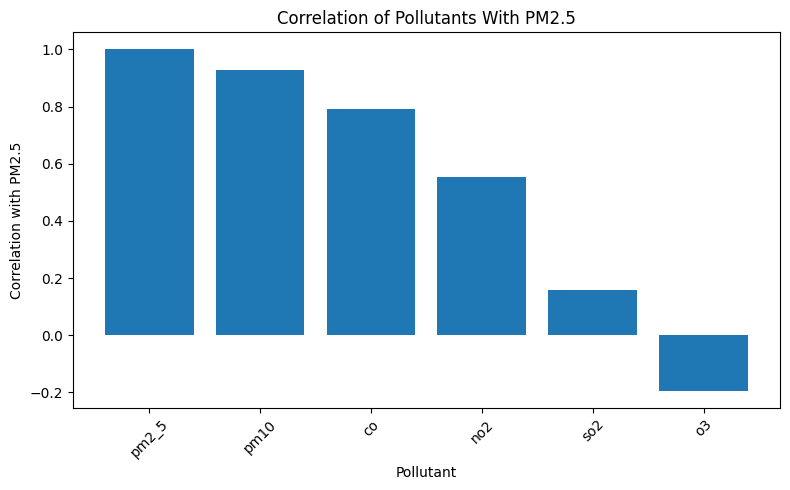

In [39]:
# CORRELATION BETWEEN POLLUTANTS
# PM2.5 is the pollutant used to calculate AQI in India
# PM2.5 has the strongest correlation with AQI

pollutants = ['pm2_5', 'pm10', 'no2', 'co', 'o3', 'so2']

corr = df[pollutants].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Between Pollutants")
plt.show()

print()



corr_with_pm25 =df[pollutants].corr()['pm2_5'].sort_values(ascending=False)
plt.figure(figsize=(8,5))
plt.bar(corr_with_pm25.index, corr_with_pm25.values)
plt.xlabel("Pollutant")
plt.ylabel("Correlation with PM2.5")
plt.title("Correlation of Pollutants With PM2.5")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



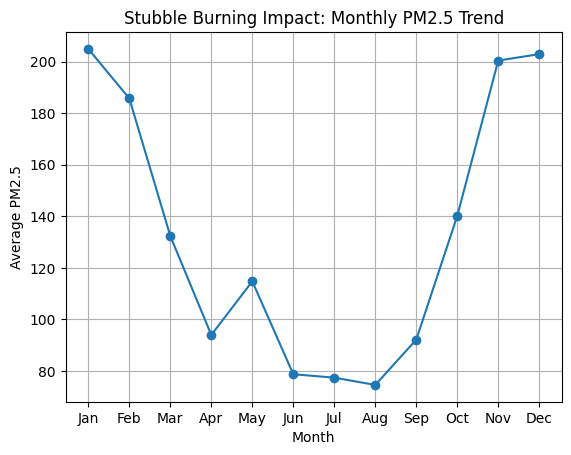

In [20]:
monthly = df.groupby('month')['pm2_5'].mean()

plt.plot(monthly.index, monthly.values, marker='o')
plt.title("Stubble Burning Impact: Monthly PM2.5 Trend")
plt.xlabel("Month")
plt.ylabel("Average PM2.5")
plt.xticks(range(1,13),
           ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.grid(True)
plt.show()


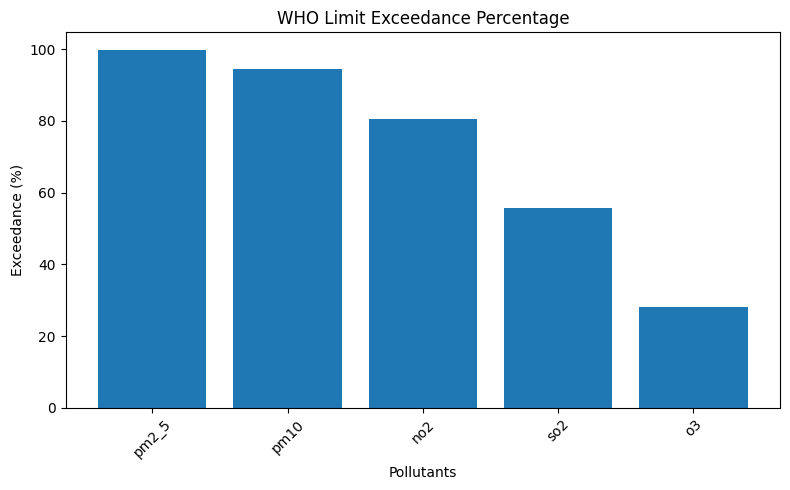

In [21]:
who_limits = {
    "pm2_5": 15,
    "pm10": 45,
    "no2": 25,
    "so2": 40,
    "o3": 100
}

exceedances = {}

for pollutant, limit in who_limits.items():
    if pollutant in df.columns:
        exceed = (df[pollutant] > limit).mean() * 100
        exceedances[pollutant] = exceed

exceedances
import matplotlib.pyplot as plt

# exceedances dictionary already computed earlier
# Example: exceedances = {"pm2_5": 40, "pm10": 70, "no2": 55, "so2": 10, "o3": 20}

pollutants = list(exceedances.keys())
values = list(exceedances.values())

plt.figure(figsize=(8,5))
plt.bar(pollutants, values)
plt.xlabel("Pollutants")
plt.ylabel("Exceedance (%)")
plt.title("WHO Limit Exceedance Percentage")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


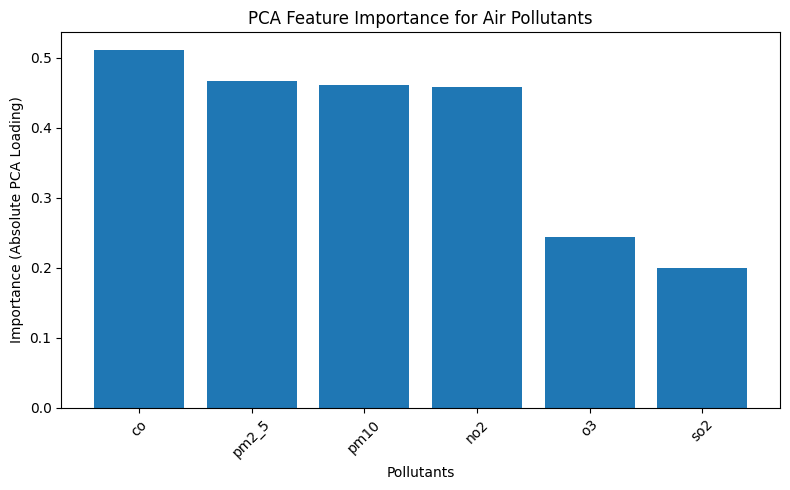

In [42]:
# PCA to find the direction of maximum variance in dataset
pollutants = ['pm2_5', 'pm10', 'no2', 'co', 'o3', 'so2']

scaler = StandardScaler()
scaled = scaler.fit_transform(df[pollutants])

pca = PCA()
pca.fit(scaled)

importance = pd.DataFrame({
    'pollutant': pollutants,
    'importance': abs(pca.components_[0])
}).sort_values(by='importance', ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(importance['pollutant'], importance['importance'])
plt.xlabel("Pollutants")
plt.ylabel("Importance (Absolute PCA Loading)")
plt.title("PCA Feature Importance for Air Pollutants")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



[64611.046057431624, 55385.76935029589, 49118.77764878042, 43236.22378062036, 38847.044358789506]


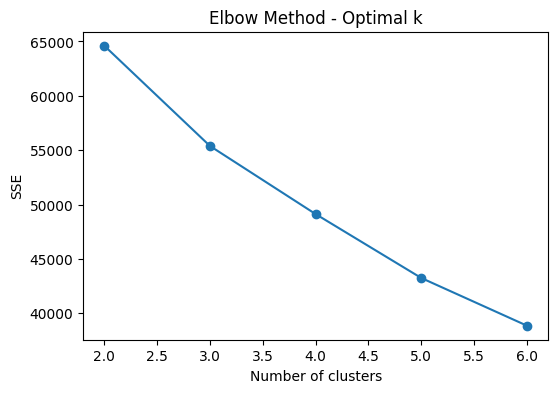


Cluster Summary (Mean Pollutant Levels):

                  co         no        no2          o3        so2       pm2_5  \
Cluster                                                                         
0        1096.718799   3.633927  36.893123   40.462840  41.561585   75.690173   
1        3101.950255  28.449477  73.477047   14.540149  55.846370  242.129174   
2         775.381049   1.801933  22.157175  167.758352  41.948183   86.836762   
3        1987.403648   4.925049  62.076849   52.425293  54.718330  175.226196   

               pm10        nh3  
Cluster                         
0        101.143595  12.609361  
1        308.106257  24.667035  
2        128.831846  10.435632  
3        223.824523  21.523053  



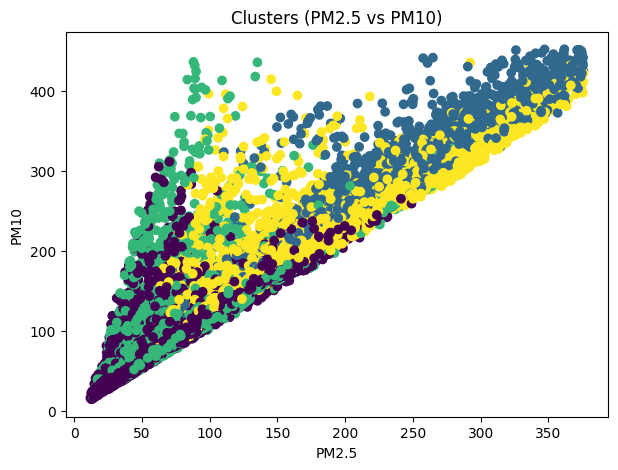


                 Color             Category
Cluster                                    
0          Dark Purple            Clean Air
1           Teal-Green   Moderate Pollution
2         Yellow-Green       High Pollution
3        Bright Yellow  Hazardous Pollution


In [48]:
# CLUSTERING
scaled_features = [
    'co_scaled', 'no_scaled', 'no2_scaled',
    'o3_scaled', 'so2_scaled', 'pm2_5_scaled',
    'pm10_scaled', 'nh3_scaled'
]

data = df[scaled_features]

sse = []

K = range(2, 7)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)
print(sse)

plt.figure(figsize=(6,4))
plt.plot(K, sse, marker='o')
plt.title("Elbow Method - Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()
# After k = 4, the improvements start slowing down noticeably.
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(data)

print("\nCluster Summary (Mean Pollutant Levels):\n")
print(df.groupby('Cluster')[[
    'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'
]].mean())
print()
plt.figure(figsize=(7,5))
plt.scatter(df['pm2_5'], df['pm10'], c=df['Cluster'], cmap='viridis')
plt.xlabel("PM2.5")
plt.ylabel("PM10")
plt.title("Clusters (PM2.5 vs PM10)")
plt.show()

print()

import pandas as pd

cluster_info = {
    0: ["Dark Purple", "Clean Air"],
    1: ["Teal-Green", "Moderate Pollution"],
    2: ["Yellow-Green", "High Pollution"],
    3: ["Bright Yellow", "Hazardous Pollution"]
}

cluster_df = pd.DataFrame.from_dict(
    cluster_info,
    orient='index',
    columns=['Color', 'Category']
)

cluster_df.index.name = "Cluster"
print(cluster_df)


